In [5]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

1.12.0+cu116


In [6]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=1.12.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric


In [7]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
import torch_geometric.nn as geonn
import torch_geometric.utils as U

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
num_features = dataset.num_node_features
num_classes = dataset.num_classes

In [10]:
from typing import Optional, Tuple, Union
from typing import Any
import math

from torch import Tensor
from torch.nn import Parameter
from torch_sparse import SparseTensor, set_diag

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import NoneType  # noqa
from torch_geometric.typing import Adj, OptPairTensor, OptTensor, Size
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax

def constant(value: Any, fill_value: float):
    if isinstance(value, Tensor):
        value.data.fill_(fill_value)
    else:
        for v in value.parameters() if hasattr(value, 'parameters') else []:
            constant(v, fill_value)
        for v in value.buffers() if hasattr(value, 'buffers') else []:
            constant(v, fill_value)

def glorot(value: Any):
    if isinstance(value, Tensor):
        stdv = math.sqrt(6.0 / (value.size(-2) + value.size(-1)))
        value.data.uniform_(-stdv, stdv)
    else:
        for v in value.parameters() if hasattr(value, 'parameters') else []:
            glorot(v)
        for v in value.buffers() if hasattr(value, 'buffers') else []:
            glorot(v)

def zeros(value: Any):
    constant(value, 0.)

class GATConvModed(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        mode: str = 'Concat',
        negative_slope: float = 0.2,
        dropout: float = 0.0,
        add_self_loops: bool = True,
        edge_dim: Optional[int] = None,
        fill_value: Union[float, Tensor, str] = 'mean',
        bias: bool = False,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.mode = mode
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops
        self.edge_dim = edge_dim
        self.fill_value = fill_value

        # In case we are operating in bipartite graphs, we apply separate
        # transformations 'lin_src' and 'lin_dst' to source and target nodes:
        if isinstance(in_channels, int):
            self.lin_src = Linear(in_channels, heads * out_channels,
                                  bias=False, weight_initializer='glorot')
            self.lin_dst = self.lin_src
        else:
            self.lin_src = Linear(in_channels[0], heads * out_channels, False,
                                  weight_initializer='glorot')
            self.lin_dst = Linear(in_channels[1], heads * out_channels, False,
                                  weight_initializer='glorot')

        # The learnable parameters to compute attention coefficients:
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))

        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False,
                                   weight_initializer='glorot')
            self.att_edge = Parameter(torch.Tensor(1, heads, out_channels))
        else:
            self.lin_edge = None
            self.register_parameter('att_edge', None)

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_src.reset_parameters()
        self.lin_dst.reset_parameters()
        if self.lin_edge is not None:
            self.lin_edge.reset_parameters()
        glorot(self.att_src)
        glorot(self.att_dst)
        glorot(self.att_edge)
        zeros(self.bias)


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None,
                return_attention_weights=None):

        H, C = self.heads, self.out_channels

        # We first transform the input node features. If a tuple is passed, we
        # transform source and target node features via separate weights:
        if isinstance(x, Tensor):
            assert x.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = x_dst = self.lin_src(x).view(-1, H, C)
        else:  # Tuple of source and target node features:
            x_src, x_dst = x
            assert x_src.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = self.lin_src(x_src).view(-1, H, C)
            if x_dst is not None:
                x_dst = self.lin_dst(x_dst).view(-1, H, C)

        x = (x_src, x_dst)

        # Next, we compute node-level attention coefficients, both for source
        # and target nodes (if present):
        alpha_src = (x_src * self.att_src).sum(dim=-1)
        alpha_dst = None if x_dst is None else (x_dst * self.att_dst).sum(-1)
        alpha = (alpha_src, alpha_dst)

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                # We only want to add self-loops for nodes that appear both as
                # source and target nodes:
                num_nodes = x_src.size(0)
                if x_dst is not None:
                    num_nodes = min(num_nodes, x_dst.size(0))
                num_nodes = min(size) if size is not None else num_nodes
                edge_index, edge_attr = remove_self_loops(
                    edge_index, edge_attr)
                edge_index, edge_attr = add_self_loops(
                    edge_index, edge_attr, fill_value=self.fill_value,
                    num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                if self.edge_dim is None:
                    edge_index = set_diag(edge_index)
                else:
                    raise NotImplementedError(
                        "The usage of 'edge_attr' and 'add_self_loops' "
                        "simultaneously is currently not yet supported for "
                        "'edge_index' in a 'SparseTensor' form")

        # edge_updater_type: (alpha: OptPairTensor, edge_attr: OptTensor)
        alpha = self.edge_updater(edge_index, alpha=alpha, edge_attr=edge_attr)

        # propagate_type: (x: OptPairTensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha, size=size)
        
        modes = {"Concat", "Maxpool", "Mean"}
        assert(self.mode in modes)
        if (self.mode == "Concat"):
            out = out.view(-1, self.heads * self.out_channels)
        elif(self.mode == "Mean"):
            out = out.mean(dim=1)
        else: #MAXPOOL
            out = (torch.max(out, dim=1))[0]

        if self.bias is not None:
            out = out + self.bias

        if isinstance(return_attention_weights, bool):
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out


    def edge_update(self, alpha_j: Tensor, alpha_i: OptTensor,
                    edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        # Given edge-level attention coefficients for source and target nodes,
        # we simply need to sum them up to "emulate" concatenation:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        if edge_attr is not None and self.lin_edge is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
            edge_attr = self.lin_edge(edge_attr)
            edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            alpha_edge = (edge_attr * self.att_edge).sum(dim=-1)
            alpha = alpha + alpha_edge
        
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha


    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return alpha.unsqueeze(-1) * x_j

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')
        

class GATCoraModed(nn.Module):
  def __init__(self, num_features, final_dim, edge_ix, hidden_features, heads, mode):
    super(GATCoraModed, self).__init__()
    self.edge_ix = edge_ix
    head_agg_dim = heads * hidden_features if (mode == "Concat") else hidden_features
    self.gatconv1 = GATConvModed(num_features, hidden_features, heads, concat=True, mode=mode)
    final_agg = "Mean"# if (mode == "Concat") else mode
    self.gatconv2 = GATConvModed(head_agg_dim, final_dim, heads, concat=True, mode=final_agg)

  def forward(self, x):
    x = self.gatconv1(x, self.edge_ix)
    x = self.gatconv2(x, self.edge_ix)
    return x

  # Used to reset the weights of the network when training multiple times with
  # different hyperparameters
  def reset_parameters(self):
      def _reset_module_parameters(module):
          for layer in module.children():
              if hasattr(layer, 'reset_parameters'):
                  layer.reset_parameters()
              elif hasattr(layer, 'children'):
                  for child_layer in layer.children():
                      _reset_module_parameters(child_layer)

      _reset_module_parameters(self)

Setup CORA and model:
The head aggregation options are: "Concat", "Maxpool", and "Mean".

In [11]:
# The Cora dataset contains a single graph of 2708 nodes (i.e., papers).
# We will use some of the nodes as training set and some as test set.
data = dataset[0].to(device)

test_mask = ~data.train_mask

# According to the GNN equations, we need the adjacency matrix to compute each
# layer convolution. The following line convert the sparse data
# (i.e., list of edges) stored in the dataset in a single dense matrix.
adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)

print(adj_matrix.shape)
print(data.edge_index.shape)

# Define the hyperparameters we are gonna use:
params = {
    "hidden_features": 128,
    "heads": 4,
    "learning_rate": 1e-4,
    "num_epochs": 100,
}

model = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   params["heads"],
                   "Concat"
  ).to(device)

torch.Size([2708, 2708])
torch.Size([2, 10556])


Test function:

In [12]:
#model.reset_parameters()
def test(model, data, adj_matrix, params):
    model.eval()

    with torch.no_grad():
      output = model(data.x)
      res = torch.argmax(output, dim=1)
      correct = (res[test_mask] == data.y[test_mask]).float().sum()
      test_accuracy = correct / len(data.y[test_mask])
    
    return test_accuracy.item()


# By testing a random initialized module you should get around ~15% accuracy
print(test(model, data, adj_matrix, params))

0.21378503739833832


Training:

In [13]:
def train(model, data, adj_matrix, params):
    model.reset_parameters()
    optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), 
            lr=params['learning_rate']
        )
    training_logs = {'losses': [], 'accuracies': []}
    test_log = {'accuracies': []}

    for epoch in range(params['num_epochs']):

      model.train() # tell the torch model it's about to be trained
      optimizer.zero_grad() # explicitly set gradients to 0 before starting backprop

      output = model(data.x)

      # compute the loss
      loss_fn = nn.CrossEntropyLoss()
      loss = loss_fn(output[data.train_mask], data.y[data.train_mask])

      # apply loss
      loss.backward()
      optimizer.step()
      res = torch.argmax(output, dim=1)
      correct = (res[data.train_mask] == data.y[data.train_mask]).float().sum()
      accuracy = correct / len(data.y[data.train_mask])
      training_logs['losses'].append(loss.item())
      training_logs['accuracies'].append(accuracy.item())

      if epoch % 32 == 0:
        print("Training - Epoch " + str(epoch) + "\nLoss: " + str(loss.item()) + "\nAccuracy: " + str(accuracy) + "\n")

      test_acc = test(model, data, adj_matrix, params)
      test_log['accuracies'].append(test_acc)

    return training_logs['losses'], training_logs['accuracies'], test_log['accuracies']


train_losses, train_accuracies, test_acc = train(model, data, adj_matrix, params)
test_accuracy = test(model, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy)

Training - Epoch 0
Loss: 1.9530842304229736
Accuracy: tensor(0.1143, device='cuda:0')

Training - Epoch 32
Loss: 1.6573365926742554
Accuracy: tensor(0.9714, device='cuda:0')

Training - Epoch 64
Loss: 1.344024658203125
Accuracy: tensor(0.9786, device='cuda:0')

Training - Epoch 96
Loss: 1.0037729740142822
Accuracy: tensor(0.9857, device='cuda:0')

Final test accuracy: 0.7830996513366699


In [14]:
#Define models with different number of heads

model2head = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   2, "Concat"
  ).to(device)

model3head = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   3, "Concat"
  ).to(device)

model4head = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   4, "Concat"
  ).to(device)

model6head = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   6, "Concat"
  ).to(device)

model8head = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   8, "Concat"
  ).to(device)



In [15]:
res2 = train(model2head, data, adj_matrix, params)
test_accuracy2 = test(model2head, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy2)

res3 = train(model3head, data, adj_matrix, params)
test_accuracy3 = test(model3head, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy3)

res4 = train(model4head, data, adj_matrix, params)
test_accuracy4 = test(model4head, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy4)

res6 = train(model6head, data, adj_matrix, params)
test_accuracy6 = test(model6head, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy6)

res8 = train(model8head, data, adj_matrix, params)
test_accuracy8 = test(model8head, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy8)

concatres = [res2, res3, res4, res6, res8]

Training - Epoch 0
Loss: 1.931856393814087
Accuracy: tensor(0.2286, device='cuda:0')

Training - Epoch 32
Loss: 1.6555137634277344
Accuracy: tensor(0.9643, device='cuda:0')

Training - Epoch 64
Loss: 1.3825035095214844
Accuracy: tensor(0.9786, device='cuda:0')

Training - Epoch 96
Loss: 1.1023468971252441
Accuracy: tensor(0.9857, device='cuda:0')

Final test accuracy: 0.7784267663955688
Training - Epoch 0
Loss: 1.9524383544921875
Accuracy: tensor(0.1214, device='cuda:0')

Training - Epoch 32
Loss: 1.6735926866531372
Accuracy: tensor(0.9143, device='cuda:0')

Training - Epoch 64
Loss: 1.3842902183532715
Accuracy: tensor(0.9643, device='cuda:0')

Training - Epoch 96
Loss: 1.0708255767822266
Accuracy: tensor(0.9714, device='cuda:0')

Final test accuracy: 0.7776479721069336
Training - Epoch 0
Loss: 1.9423809051513672
Accuracy: tensor(0.2071, device='cuda:0')

Training - Epoch 32
Loss: 1.6461862325668335
Accuracy: tensor(0.9643, device='cuda:0')

Training - Epoch 64
Loss: 1.33358895778656
A

In [24]:
#TRY MAXPOOLING
#Define models with different number of heads

model2headpool = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   2, "Maxpool"
  ).to(device)

res2pool = train(model2headpool, data, adj_matrix, params)
test_accuracy2pool = test(model2headpool, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy2pool)

model3headpool = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   3, "Maxpool"
  ).to(device)

res3pool = train(model3headpool, data, adj_matrix, params)
test_accuracy3pool = test(model3headpool, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy3pool)

model4headpool = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   4, "Maxpool"
  ).to(device)

res4pool = train(model4headpool, data, adj_matrix, params)
test_accuracy4pool = test(model4headpool, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy4pool)

model6headpool = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   6, "Maxpool"
  ).to(device)

res6pool = train(model6headpool, data, adj_matrix, params)
test_accuracy6pool = test(model6headpool, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy6pool)

model8headpool = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   8, "Maxpool"
  ).to(device)

res8pool = train(model8headpool, data, adj_matrix, params)
test_accuracy8pool = test(model8headpool, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy8pool)

maxres = (res2pool, res3pool, res4pool, res6pool, res8pool)

Training - Epoch 0
Loss: 1.9427686929702759
Accuracy: tensor(0.2214, device='cuda:0')

Training - Epoch 32
Loss: 1.7355848550796509
Accuracy: tensor(0.9714, device='cuda:0')

Training - Epoch 64
Loss: 1.527125358581543
Accuracy: tensor(0.9786, device='cuda:0')

Training - Epoch 96
Loss: 1.304888129234314
Accuracy: tensor(0.9857, device='cuda:0')

Final test accuracy: 0.7780373692512512
Training - Epoch 0
Loss: 1.9381616115570068
Accuracy: tensor(0.1643, device='cuda:0')

Training - Epoch 32
Loss: 1.7566092014312744
Accuracy: tensor(0.9357, device='cuda:0')

Training - Epoch 64
Loss: 1.5660686492919922
Accuracy: tensor(0.9857, device='cuda:0')

Training - Epoch 96
Loss: 1.353902816772461
Accuracy: tensor(0.9929, device='cuda:0')

Final test accuracy: 0.753894031047821
Training - Epoch 0
Loss: 1.941400170326233
Accuracy: tensor(0.1500, device='cuda:0')

Training - Epoch 32
Loss: 1.7870146036148071
Accuracy: tensor(0.9214, device='cuda:0')

Training - Epoch 64
Loss: 1.619794249534607
Accu

In [17]:
#TRY MAXPOOLING
#Define models with different number of heads

model2headmean = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   2, "Mean"
  ).to(device)

res2mean = train(model2headpool, data, adj_matrix, params)
test_accuracy2mean = test(model2headmean, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy2mean)

model3headmean = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   3, "Mean"
  ).to(device)

res3mean = train(model3headmean, data, adj_matrix, params)
test_accuracy3mean = test(model3headmean, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy3mean)

model4headmean = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   4, "Mean"
  ).to(device)

res4mean = train(model4headmean, data, adj_matrix, params)
test_accuracy4mean = test(model4headmean, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy4mean)

model6headmean = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   6, "Mean"
  ).to(device)

res6mean = train(model6headmean, data, adj_matrix, params)
test_accuracy6mean = test(model6headmean, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy6mean)

model8headmean = GATCoraModed(num_features, 
                   num_classes,data.edge_index, 
                   params["hidden_features"],
                   8, "Mean"
  ).to(device)

res8mean = train(model8headmean, data, adj_matrix, params)
test_accuracy8mean = test(model8headmean, data, data.edge_index, params)
print("Final test accuracy:", test_accuracy8mean)

resmean = (res2mean, res3mean, res4mean, res6mean, res8mean)

Training - Epoch 0
Loss: 1.9462556838989258
Accuracy: tensor(0.1357, device='cuda:0')

Training - Epoch 32
Loss: 1.7435446977615356
Accuracy: tensor(0.9429, device='cuda:0')

Training - Epoch 64
Loss: 1.5373541116714478
Accuracy: tensor(0.9786, device='cuda:0')

Training - Epoch 96
Loss: 1.3146127462387085
Accuracy: tensor(0.9786, device='cuda:0')

Final test accuracy: 0.14291277527809143
Training - Epoch 0
Loss: 1.9440451860427856
Accuracy: tensor(0.1286, device='cuda:0')

Training - Epoch 32
Loss: 1.7934287786483765
Accuracy: tensor(0.9571, device='cuda:0')

Training - Epoch 64
Loss: 1.6306098699569702
Accuracy: tensor(0.9714, device='cuda:0')

Training - Epoch 96
Loss: 1.441957950592041
Accuracy: tensor(0.9714, device='cuda:0')

Final test accuracy: 0.7725856304168701
Training - Epoch 0
Loss: 1.9464529752731323
Accuracy: tensor(0.1000, device='cuda:0')

Training - Epoch 32
Loss: 1.8231210708618164
Accuracy: tensor(0.9571, device='cuda:0')

Training - Epoch 64
Loss: 1.684050083160400

Let's plot the result:

In [18]:
import matplotlib.pyplot as plt

Maxpooling plots 

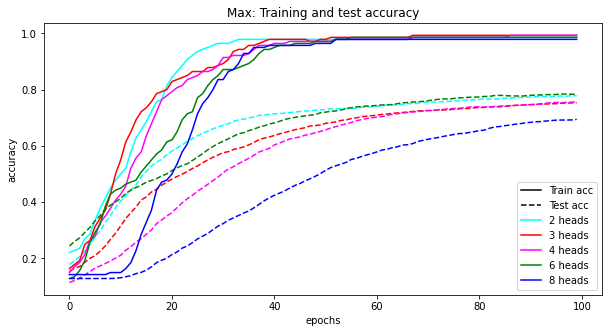

In [25]:
head_nb = [2, 3, 4, 6, 8]
colours = ["cyan", "red", "magenta", "green", "blue"]

plt.figure(figsize=(10,5))
plt.title("Max: Training and test accuracy")
plt.plot([], label="Train acc", color = "black")
plt.plot([], label='Test acc',color = "black", linestyle='dashed')
for i, res in enumerate(maxres):
    _, train_acc_pool, test_acc_pool = res
    plt.plot(test_acc_pool, color = colours[i], linestyle='dashed')
    plt.plot(train_acc_pool, label=str(head_nb[i]) + " heads", color = colours[i])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

#best: 4heads 

Mean plots 

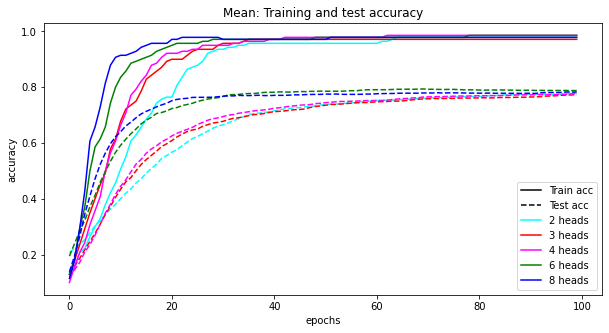

In [20]:
plt.figure(figsize=(10,5))
plt.title("Mean: Training and test accuracy")
plt.plot([], label="Train acc", color = "black")
plt.plot([], label='Test acc',color = "black", linestyle='dashed')
for i, res in enumerate(resmean):
    _, train_acc_pool, test_acc_pool = res
    plt.plot(test_acc_pool, color = colours[i], linestyle='dashed')
    plt.plot(train_acc_pool, label=str(head_nb[i]) + " heads", color = colours[i])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

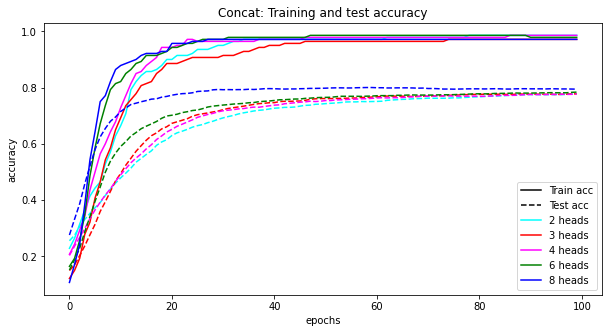

In [21]:
plt.figure(figsize=(10,5))
plt.title("Concat: Training and test accuracy")
plt.plot([], label="Train acc", color = "black")
plt.plot([], label='Test acc',color = "black", linestyle='dashed')
for i, res in enumerate(concatres):
    _, train_acc_pool, test_acc_pool = res
    plt.plot(test_acc_pool, color = colours[i], linestyle='dashed')
    plt.plot(train_acc_pool, label=str(head_nb[i]) + " heads", color = colours[i])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Comparison of final accuracies

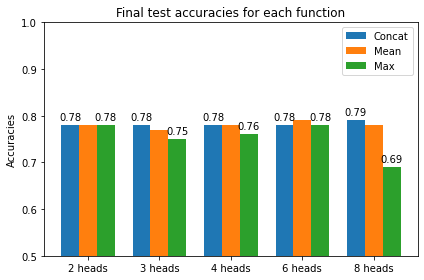

In [35]:
concat_final = []
for r in concatres:
    _, _, t_acc = r
    concat_final.append(round(t_acc[-1], 2))

mean_final = []
for r in resmean:
    _, _, t_acc = r
    mean_final.append(round(t_acc[-1], 2))

max_final = []
for r in maxres:
    _, _, t_acc = r
    max_final.append(round(t_acc[-1], 2))

labels = ['2 heads', '3 heads', '4 heads', '6 heads', '8 heads']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, concat_final, width, label='Concat')
rects2 = ax.bar(x, mean_final, width, label='Mean')
rects2 = ax.bar(x + width, max_final, width, label='Max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracies')
ax.set_title('Final test accuracies for each function')
ax.set_xticks(x, labels)
ax.legend()
ax.set_ylim([0.5, 1])

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()
